1. Загрузка и предварительный анализ данных

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
df = pd.read_csv('../data/prostate/prostate.txt', delim_whitespace=True)

# Исправление известной ошибки в данных
df.loc[df['lweight'] > 6, 'lweight'] = np.log(44.9)  # Исправление веса простаты

# Разделение на обучающую и тестовую выборки согласно указанию в данных
train = df['train'] == 'T'
X_train = df[train].iloc[:, :8]  # Признаки (колонки 1-8)
y_train = df[train]['lpsa']      # Целевая переменная (lpsa)
X_test = df[~train].iloc[:, :8]
y_test = df[~train]['lpsa']

C:\Users\pc\AppData\Local\Temp\ipykernel_2736\185019806.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('../data/prostate/prostate.txt', delim_whitespace=True)


2. Специальное масштабирование признаков

In [15]:
# Масштабирование с дисперсией n=96 (как указано в описании)
n = len(X_train)
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_scaled = scaler.fit_transform(X_train) * np.sqrt(n)
X_test_scaled = scaler.transform(X_test) * np.sqrt(n)

# Проверка дисперсии
print("Дисперсия признаков после масштабирования:", np.var(X_train_scaled, axis=0))

Дисперсия признаков после масштабирования: [68. 68. 68. 68. 68. 68. 68. 68.]


3. Обучение и сравнение моделей

In [16]:
# Список моделей для сравнения
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression (α=1)': Ridge(alpha=1.0),
    'Lasso Regression (α=0.1)': Lasso(alpha=0.1)
}

# Обучение и оценка моделей
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    results[name] = {
        'MSE': mean_squared_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred),
        'model': model
    }
    
    print(f"{name}:")
    print(f"  MSE = {results[name]['MSE']:.4f}")
    print(f"  R² = {results[name]['R2']:.4f}\n")

Linear Regression:
  MSE = 0.5394
  R² = 0.4986

Ridge Regression (α=1):
  MSE = 0.5393
  R² = 0.4988

Lasso Regression (α=0.1):
  MSE = 0.5122
  R² = 0.5239



4. Анализ лучшей модели

Лучшая модель: Lasso Regression (α=0.1)

Важность признаков:


,Признак,Коэффициент
0,lcavol,0.081564
1,lweight,0.034088
4,svi,0.033973
7,pgg45,0.026418
5,lcp,-0.025204
3,lbph,0.023970
2,age,-0.013775
6,gleason,-0.000000


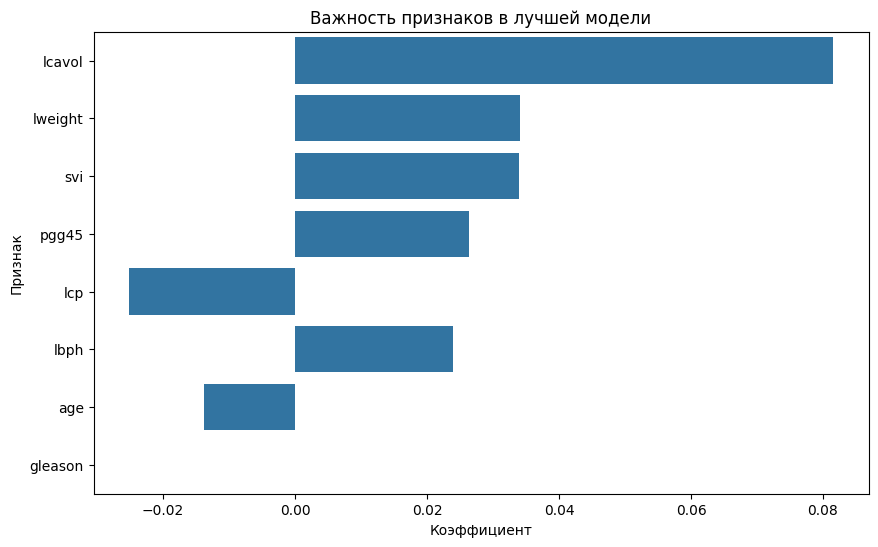

In [17]:
# Выбор лучшей модели по MSE
best_model_name = min(results, key=lambda x: results[x]['MSE'])
best_model = results[best_model_name]['model']
print(f"Лучшая модель: {best_model_name}")

# Коэффициенты модели
coef_df = pd.DataFrame({
    'Признак': X_train.columns,
    'Коэффициент': best_model.coef_
}).sort_values('Коэффициент', key=abs, ascending=False)

print("\nВажность признаков:")
display(coef_df)

# Визуализация коэффициентов
plt.figure(figsize=(10, 6))
sns.barplot(x='Коэффициент', y='Признак', data=coef_df)
plt.title('Важность признаков в лучшей модели')
plt.show()

5. Оценка качества на тестовой выборке

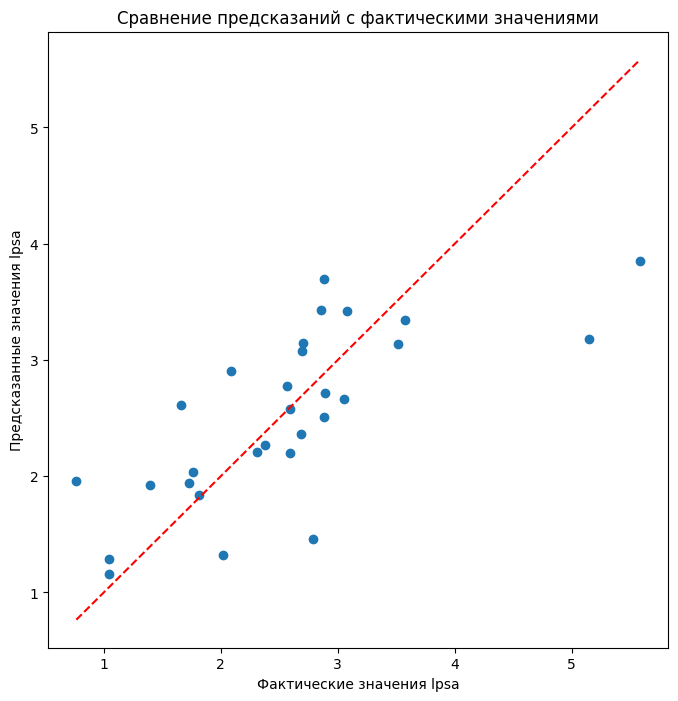

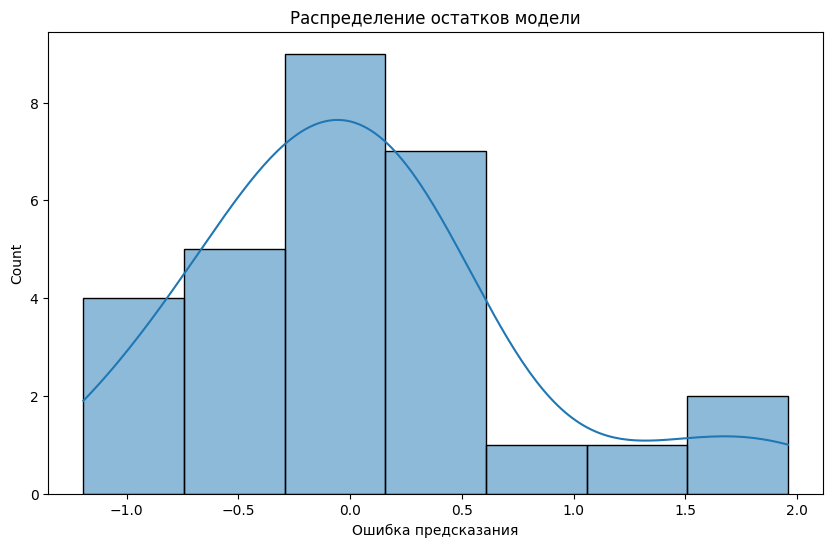

In [18]:
# Предсказания vs фактические значения
y_pred = best_model.predict(X_test_scaled)

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Фактические значения lpsa')
plt.ylabel('Предсказанные значения lpsa')
plt.title('Сравнение предсказаний с фактическими значениями')
plt.show()

# Остатки модели
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Распределение остатков модели')
plt.xlabel('Ошибка предсказания')
plt.show()

6. Сохранение результатов

In [19]:
import json
import joblib

# Сохранение результатов
final_results = {
    'best_model': best_model_name,
    'test_mse': float(results[best_model_name]['MSE']),
    'test_r2': float(results[best_model_name]['R2']),
    'coefficients': coef_df.to_dict('records'),
    'n_train_samples': len(X_train),
    'n_test_samples': len(X_test)
}

with open('../results/task4_final_results.json', 'w') as f:
    json.dump(final_results, f, indent=2)

# Сохранение модели
joblib.dump(best_model, '../models/prostate_best_model.pkl')

['../models/prostate_best_model.pkl']